# Objective : 
- To get Optimum $\theta_0$ and $t_{burn}$

# Given:
- $S_{threshold} = 70 m $
- $Thrust_{availablle} = 1068 kN$
- $\frac{dm}{dt} = 78.75 kg/sec$  

# Assumption
- The parent is flying at an constant angle with the horizon, with gravity, thrust and drag acting on it

# Intermediate Calci: 
- Drag Calci:
    - $ Area_{projected} = \pi(\frac{5}{2})^2 sin(\beta) + 10\times 5 cos(\beta) $
    - $C_D$ assumed constant for $\beta\in (0\degree,5\degree)$ : validation link https://iopscience.iop.org/article/10.1088/1757-899X/225/1/012045/pdf#:~:text=In%20case%20of%20blunt%20bodies,increases%20for%20all%20Mach%20numbers

# Playing Relative Game

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# link for Cd not varying much https://iopscience.iop.org/article/10.1088/1757-899X/225/1/012045/pdf#:~:text=In%20case%20of%20blunt%20bodies,increases%20for%20all%20Mach%20numbers

In [2]:
# Constants
S_thold = -70
T_av = 1108e3
dmByDt = 78.75
A_side_proj = 10*5
A_front_proj = np.pi*2.5*2.5

In [3]:

THETA = 3 # in degrees
MASS = 6e3 # in kg
DT = 0.001 # in seconds

def thrust(alpha,theta=np.deg2rad(THETA),T=(1e6 + MASS*1*9.8)/np.cos(np.deg2rad(THETA)),mass=MASS):
    """ 
    calculates thrust in inertial (parent) direction
    inputs:
    - alpha in rad
    - theta in rad
    - T in N (absolute value of net thrust)

    output:
    - 2D vector

    Notes: value of T*cos(theta) = Drag + ma
    """
    return np.array([T*np.cos(-alpha+theta),-T*np.sin(-alpha+theta)-mass*9.8])

def drag(alpha,beta,D = 1e6):
    """
    calculates drag in inertial (parent) direction
    inputs:
    - alpha in rad
    - beta in rad
    - D in N (absolute value of net thrust)

    output: 
    - 2D vector
    """
    return np.array([-D*np.cos(beta-alpha),D*np.sin(beta-alpha)])

def R_i2b(alpha,vec):
    """ 
    returns rotated vector in the body frame (x,y) from the interial {parent (X,Y)}
    alpha in rad
    """
    rotMat = np.array( [ [ np.cos(alpha), np.sin(alpha) ], [ -np.sin(alpha), np.cos(alpha)] ] )   
    return np.matmul(rotMat,vec)

def moment(alpha, drag, l = 0.5):
    """ 
    calculates positive value standard right hand rule i.e. outside plane moment is positive
    l is distance between cg and cp
    distance between cg and ct is assumed 0 {ct is the point at which thrust acts}
    """
    dragRot = -R_i2b(alpha,drag)
    return dragRot[1]*l

def moi(m=6000,r=2.5,l=10):
    """
    moment of intertia, will be used in future for variable mass and exact CG location
    """
    return m*(0.25*r**2 + (1/12)*l**2)+m*(1.5)**2


def betaFromV(alpha, v):
    """
    input:
    - alpha in radians
    - velocity vector in inertial frame
    output:
    - in radians
    """
    vRot = R_i2b(alpha,v) # transform velcity vector from parent to pod frame
    return np.arctan(-vRot[1]/vRot[0])

def updateV(vo, T, D, dt = DT, m = MASS):
    """
    newton's law
    """
    # return vo + ((T+D)/m+np.array([0,-9.8]))*dt # for absolute displacement in Y (but first have to rotate everything in real inertial frame)
    return vo + ((T+D)/m)*dt

def updateAlphadot(alphaDot, moment, moi, dt = DT):
    """
    we know that doube derivative of alpha wrt time is net_Torque/Moment of inertia
    input:
    - rad/sec
    - N-m
    - kg-m^2
    """
    return alphaDot + (moment/moi)*dt

def updateAlpha(alphao, alphaDot, dt = DT):
    """ 
    took modulus for plots
    """
    # return (alphao + alphaDot*dt)%(2*np.pi)
    return (alphao + alphaDot*dt)

def getAngle(vec):
    return np.arctan(vec[1]/vec[0])


In [4]:
def loopAll( theta = 7,dragNew = 1e6,loopTime = 5):
    MASS = 6e3
    #declaring empty arrays
    t = np.arange(0,loopTime+DT,DT) 
    alph = np.zeros(len(t))
    bet = np.zeros(len(t))
    T = np.zeros((len(t),2))
    D = np.zeros((len(t),2))
    V = np.zeros((len(t),2))
    alphDot = np.zeros(len(t))
    tau = np.zeros(len(t)) 
    
    # initializing t = 0 values
    T[0] = thrust(alph[0],np.deg2rad(theta),T_av)
    D[0] = drag(alph[0],bet[0],dragNew)
    V[0] = np.array([600,0])
    I = moi()
    updatedMASS = MASS
    for i in range(1,len(t)):
        updatedMASS = MASS - 4*dmByDt*DT
        V[i] = updateV(V[i-1],T[i-1],D[i-1],DT,updatedMASS)
        bet[i] = betaFromV(alph[i-1],V[i])
        tau[i] = moment(alph[i-1],D[i-1])
        alphDot[i] = updateAlphadot(alphDot[i-1],tau[i],moi(updatedMASS))
        alph[i] = updateAlpha(alph[i-1],alphDot[i-1])
        T[i] = thrust(alph[i],np.deg2rad(theta),T_av)
        D[i] = drag(alph[i],bet[i],dragNew)
    return alph,bet,V

In [5]:
def get_tburnFromS(sy):
    idx = np.argmin(np.abs(sy - S_thold))
    return idx

In [6]:
thetaOptArr = np.arange(0,10,0.1)
thrustReqOpt = np.zeros( len(thetaOptArr))
tburnOpt = np.zeros( len(thetaOptArr))

In [7]:
for i in range(0,len(thetaOptArr)):
    alphOpt,betOpt,velOpt = loopAll(thetaOptArr[i])
    SOpt = np.array([np.cumsum(velOpt[:,0]),np.cumsum(velOpt[:,1])])*DT
    tburnOpt[i] = get_tburnFromS(SOpt[1])
    maxbetOpt = np.max(betOpt)
    dragNewOpt = ( ( A_side_proj * np.sin(maxbetOpt) + A_front_proj * np.cos(maxbetOpt) ) / A_front_proj)*1e6
    thrustReqOpt[i] = (dragNewOpt*(np.cos(maxbetOpt)) + MASS*1*9.8)/np.cos(np.deg2rad(thetaOptArr[i]))
    # if(thrustReqOpt>T_av):
    #     print(thetaOptArr[i])
    #     break


In [8]:
np.argmin(np.abs(thrustReqOpt-T_av)) #index for optimum value

61

In [11]:
tburnOpt[61] # time of burn for optimum value

2206.0

In [12]:
thetaOptArr[61] # theta for optimum value in degree

6.1000000000000005

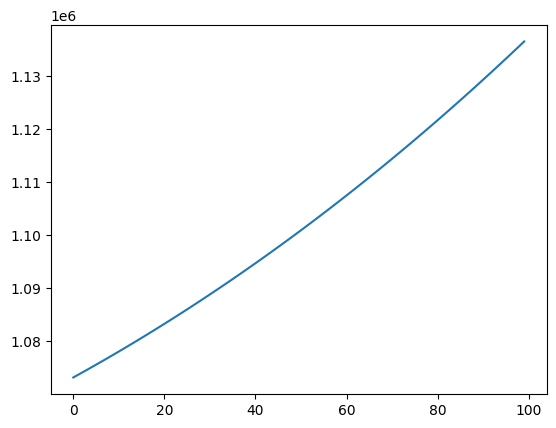

In [13]:
plt.plot(thrustReqOpt)